# 03- Calculating the chi2 with the loop code

This notebook described the use of the loop.py (or loop_speed.py) function that makes the chi square calculation between the synthetic Stokes V profiles and a pyRaven observation packet, for a grid of magnetic dipole parameter values. 

## 0. Importing the necessary packages

In [14]:
import specpolFlow as pol
import numpy as np
import matplotlib.pyplot as plt
import copy

import pyRaven as rav

## 1. What is the goal of this code?

The goal of this piece of the bayesian analysis is to create a synthetic Stokes V profile for each parameter set on a grid, and calculate the chi2 between this profile and the observations. These 4D grids of chi2 are saved as h5 files.

To run this piece of the code, we need 2 things:
* An Observation Packet
* A parameter dictionary that will contain:
    - **The ['general'] parameters** that define the Stokes I profile (see previous notebook), and the general information that is necessay for the Stokes V profile (e.g. the wavelength of the transition)
    - **The ['weak'] parameters** which contains the parameter for the weak-field solution (as opposed to the unno solution), namely the effective landé factor. Note that the loop only performs weak-field calculation. 
    - **The ['grid'] parameters** which defines the grid of parameters for the dipolar field model (Bpole, beta, phi, incl -- see below)

The `rav.loop.loop` function itself takes already loaded Observation Packet object and parameter dictionary object. The loop function writes the chi2 files in the current directory but a path can be specified. 

Here's an example of a workflow doing the object loading directly:
```
Packet = rav.data.read_packet('../Data/hd12345.h5')
Params = rav.param.read_parameters('../Data/hd12345.h5')
rav.loop_speed.loop_speed(Packet, Params, path='loop_output/')
```

We also provide a wrapper function that will take filenames as input for the packet and the parameters dictionary, for example:
```
rav.loop_speed.loop_speed_wrapper('packet.h5', 'params.jason')
```

Note that this is the most time consuming part of the bayesian analysis. The larger your parameter grid, and the larger the star's vsini, the more time it will take. 

The code outputs a message at the end of each of the outer-loop on the inclination angle, with the time spent (in seconds). 

There are two versions of the loop code: 'loop' and 'loop_speed'. The latter uses the package 'numba' to compile pieces of the inner loops for speed. 

To reduce memory usage, the code will output a chi2 file for each inclination angle value in the grid. It will furthermore create a separate file for each observations, and for each Stokes parameter. 
The file format is as follow: `chi[S]_i[i]obs[o].h5` where `[S]` is 'V' or 'N1', `[i]` is the index of the inclination value, and `[o]` is the index of the observation. 

For more information about the structure of a chi2 file, see the tutorial on the BayesObject class https://veropetit.github.io/pyRaven/nblink/BayesObjects_user.html, or the class API https://veropetit.github.io/pyRaven/API.html#module-pyRaven.BayesObjects. 

## 2. Choice of grid parameters, and necessary other parameters

In this section, we discuss the parameters that are required by the loop code. 

We also discuss how to choose the grid of parameters for the dipolar field model. This includes:
* how to decide on an upper limit for Bpole
* how to decide on a lower limit on the inclination angle. 

As this is a tutorial, this section includes loading and visualzing the DataPacket and the models. Note that this is not strickly necessary for a pyRaven workflow. 

In the cell below, we load and display our example DataPacket from Notebook 01 ([in docs](https://veropetit.github.io/pyRaven/nblink/01-DataSetup.html), [in github](https://github.com/veropetit/pyRaven/blob/main/HowToUsePyRavenTutorial/01-DataSetup.ipynb)) which contains 3 LSD profiles that have been scaled, normalized, and cut to include only the portion of the line profile that will be used for the calculation of the chi square (right-hand graph). 

We also generate a parameter dictionary (explicitely) with the parameters we have decided upon in the previous notebook for the fit to the Stokes I profile. We overplot the fit in dashed black in the two right-hand panels. 

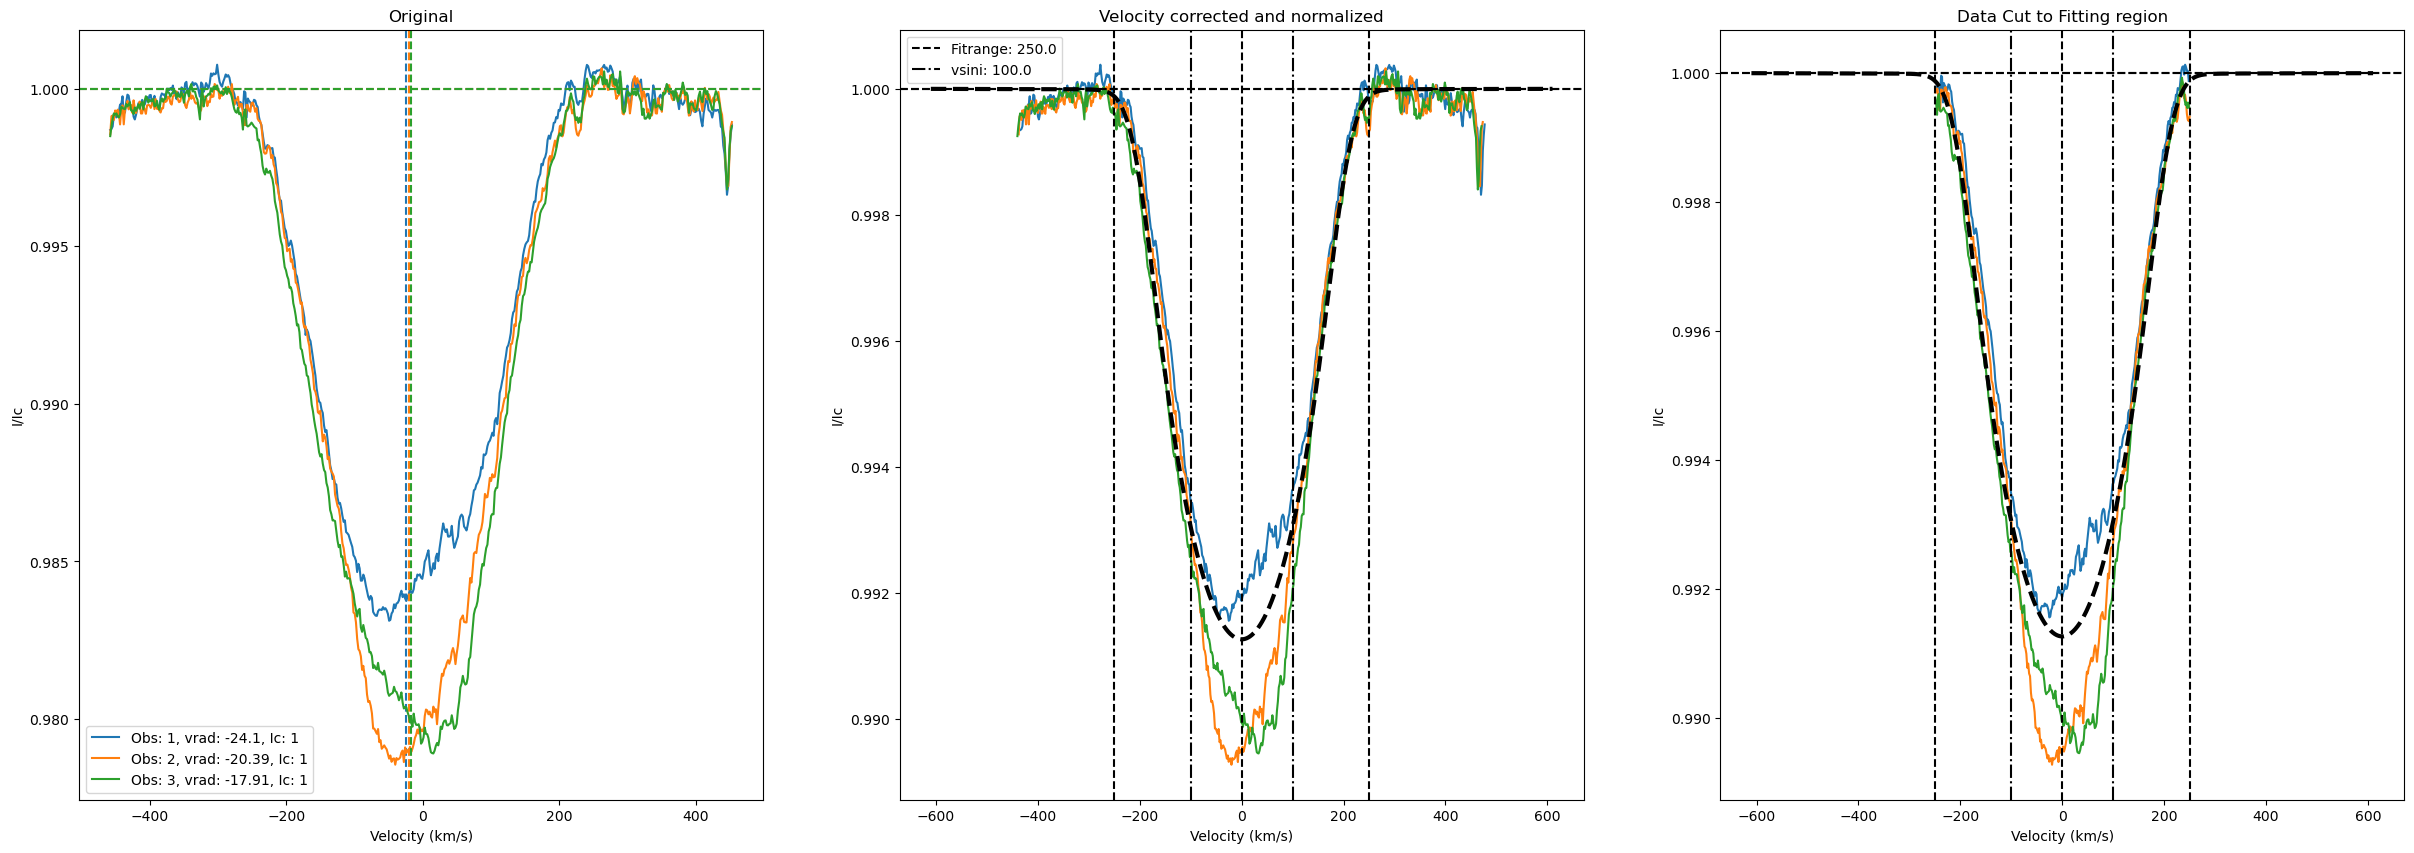

In [2]:
Packet = rav.data.read_packet('ExampleData/ExamplePacket.h5')
fig, ax = Packet.plotI()

# Parameters we have settled on in the previous notebook:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':200.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':-0.20,          # the line strength parameter
    'ndop':int(10),       # the number of sample point per doppler width for the wavelength array
    'res':65000,
    'vmac':30,
  }
param={'general' : genparam
       }

# Calculate an analytical model and overplot on the last two graphs
# (not the first one, as the profiles have been normalized to continuum
# and scaled to the LSD weigths we have decided to use)
model = rav.diskint2.analytical(param)
for item in ax[1:3]:
  item.plot(model['vel'], model['flux'], c='k', ls='--', lw=3)

### 2.1 Setting the Landé factor

For the calculation of the synthetic profiles with the weak-field approximation, we have to explicitly set the effective Landé factor. We have already set a wavelength of 5000 A in our 'general' parameter dictionary (note -- for Stokes I analytical calculation, this parameter is only used to create a wavelength dispersion axis in the output model). 

This mean that in combination with the LSD weigths, the Landé factor is fixed. 

In the example above, we set the intesity weigth (wint) to be 0.1, and the polarization weigth (wpol) to be 60. As wpol = wavelength(nm) * Landé * wint, then this implies that the effective Landé factor for this LSD profile model should be set to 1.2.   

In [3]:
weakparam = {
        'geff':1.2
    }
param={'general' : genparam,
        'weak' : weakparam
       }

### 2.2 Evaluating the maximum Bpole to use in the grid

We need to decide that maximum Bpole to use for our grid of dipolar magnetic field parameters. We can do this by examining the field strengths that would nominally create a Stokes V signature that is quite larger than the noise level is Stokes V and/or in the null profiles. 

To make a Stokes V calculation, we will use the rav.diskint2.numerical function. This function is a standalone to make a single Stokes V calculation. (Note: The loop code that calculates the chi2 do not call this function, as it would not have been efficient. But they share the same set of module functions and the Stokes V calculated in the loop funciton matches that of the numerical function exactly). 

To run rav.diskint2.numerical, we need to define some extra parameters in the 'general' parameter dictionary:
- The dipolar field strength Bpole in Gauss
- The inclination of the rotational axis to the line of sight incl in degree
- The obliquity of the magnetic axis to the rotation axis beta in degree
- The rotational phase ***in degree***

The maximum amplitude of the Stokes V signature will be when the dipole is aligned with line of sight. We will make that happen by setting
- incl = 90 (degrees)
- beta = 90 (degrees)
- phase = 0 (degree)

Here, we will want to find the value of Bpole that will generate a Stokes V profile that is aprreciably above the noise level of your LSD profiles (if there is no obvious Stokes V signal present), or above the Stokes V signature. 

In the example above, 5000 gauss seems reasonable for the goal of the project that was associated with these data. This choice depends on your own research project goal, and should be discussed in your paper. 




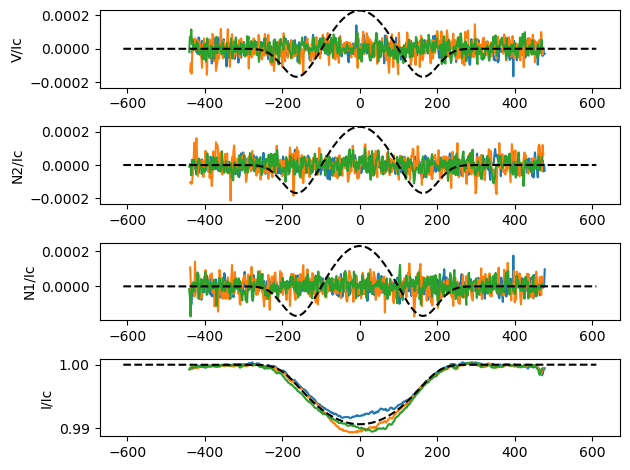

In [19]:
# make a copy of the parameters that are defined for the Stokes I fit
magparam = copy.copy(genparam)
# Add parameters for the dopolar field configuration
magparam['Bpole'] = 5000
magparam['incl'] = 90
magparam['beta'] = 90
magparam['phase'] = 90

param = param={'general' : magparam,
        'weak' : weakparam
       }

model = rav.diskint2.numerical(param)

# Make a graph of the Scaled LSD profiles in the data Packet
fig, ax = Packet.scaled.plot()
# Overplot the calculated model
ax[3].plot(model['vel'], model['flux'], ls='--', c='k')
for item in ax.flatten()[0:3]:
       item.plot(model['vel'], model['V'], ls='--', c='k')

### 2.3 Determining the limits on the inclination based on vsini and critical velocity

There are two reasons to limit the range of inclinations in the bayesian grid. 

1. The default prior probability distribution used in pyRaven is a sin(i) distribution, to reflect the expected randomness of the rotational axis with respect to Earth. This means that the prior probability density at 0 and 180 degree will be exactly zero. This in itself is not a scientific issue. However, because of the large range of values encoutered in probability densities, all of the calculation are done in logarithmic space. Python does not mind too much, as the transformation from ln(P) to P during marginalization and normalization have been designed to avoid overflow. Very underflow probability densities are handeled as -inf in log space, and return 0 when exponentiated. However, this procedure will return a 'division by zero' warning. Additionally, the `BayesObjects.exp_check()` and `BayesObject.ln_mar_check()` used throughout the code will also return a direct warning that a nan or inf was encourtered, so that you can verify that this did not happen for an unexpected reason. In principle, this should not happen, as there is also a physical reason for the grid of inclination not to go to 0 or 180.

2. 

BELOW STILL NEED CLEANUP



We are here generating the data structures that contains information for the codes:
* genparam: general parameters, same as for diskint2 function. However the Bpole, incl, beta, and phase parameters are not necessary here, as they will be set by the gridparam structure. This said, one can still pass a genparam structure that was used for diskint2 -- the extra parameters are simply ignored. 
* weakparam: the lande factor for the weak field approximation
* gridparam: contains the arrays defining the grid for the dipolar parameters. 

See INSERT LINK HERE for many additional way to create param objects (including from files). 

Here we have set the intensity line profile model parameters to already known values for this dataset. In the middle plot below, we show the model line profile (dashed curve) in the middle panel. 

If you have yet to fit your line profiles to determine the appropriate vsini, vmac, and logkappa, see INSERT LINK HERE.

We also save the the param to a folder in the repository ExampleData/LoopExample. Although not strickly necessary, it will be useful to make more lengtly calculations with a script on a more powerful computer. 

1.958617462625618
Using 9000.0 grid point on the surface
Evaluating with weak approximation...


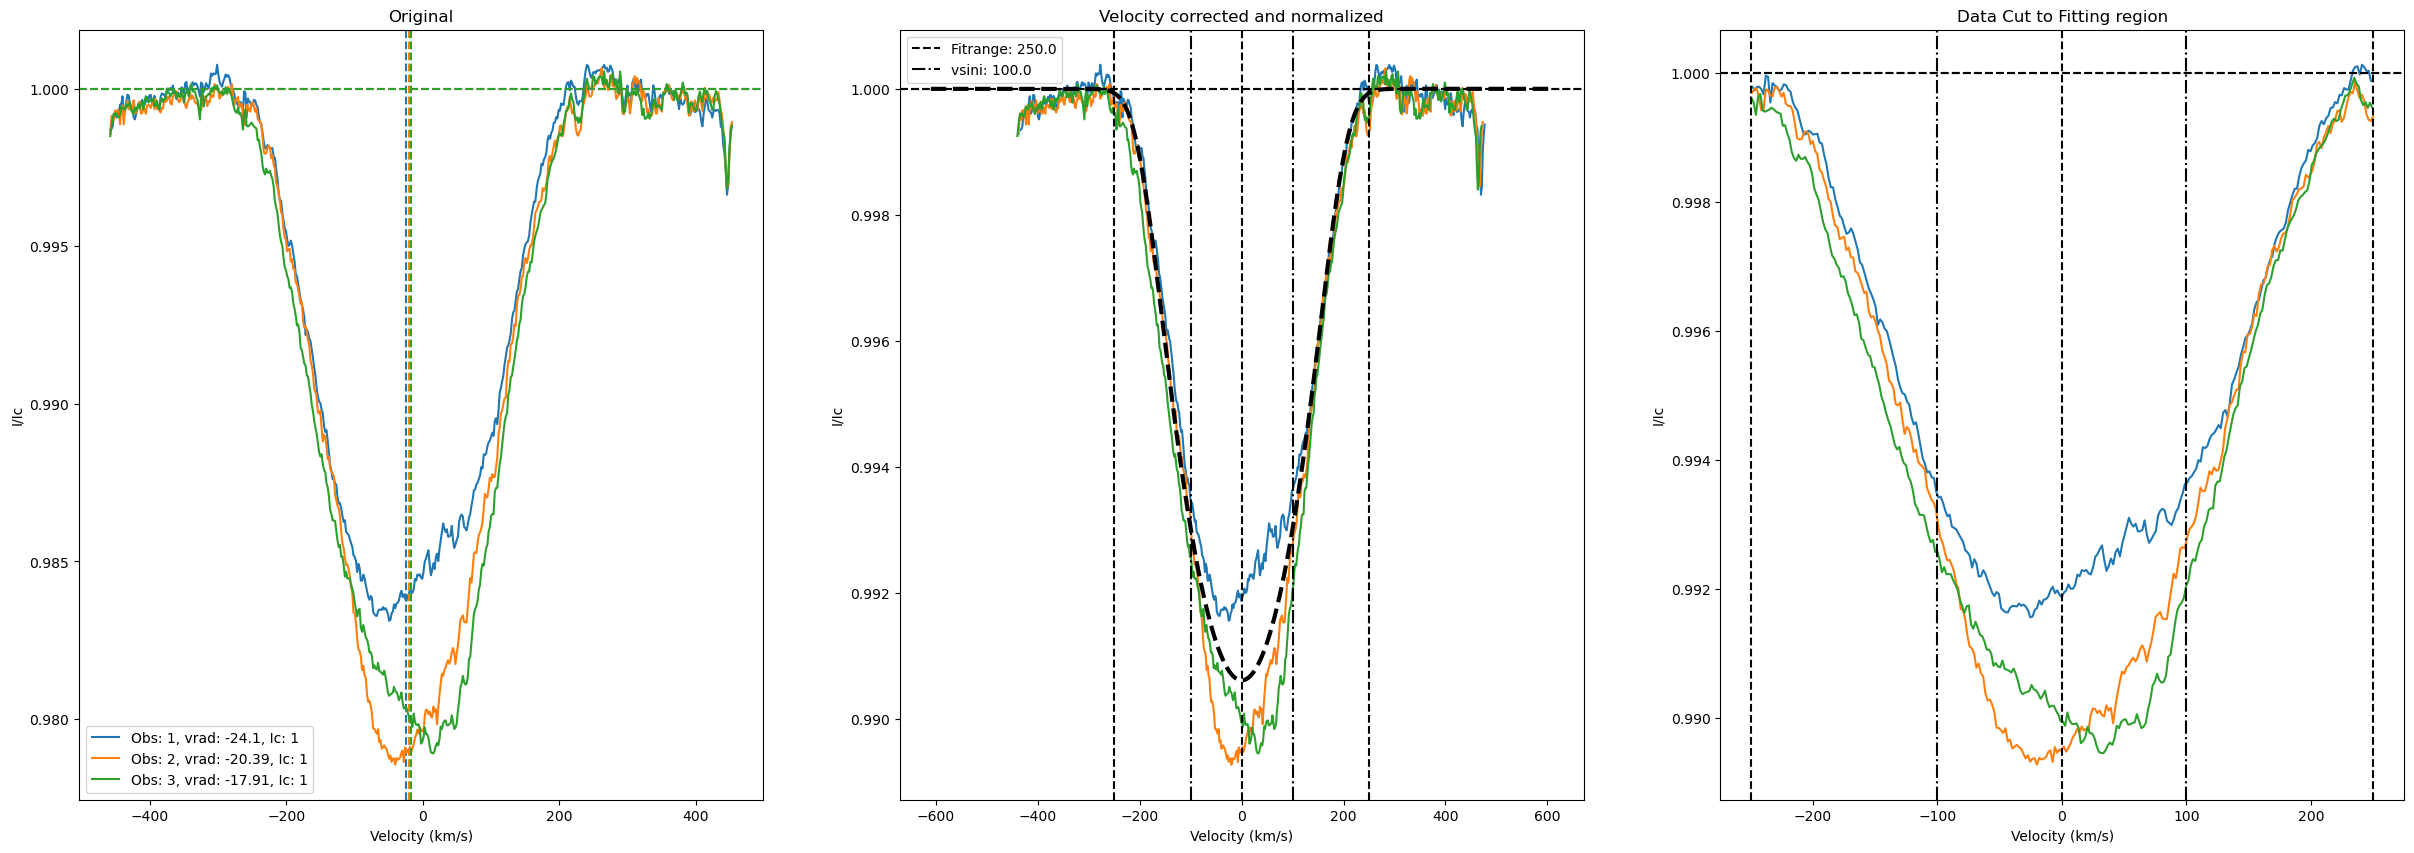

In [3]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':200.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':-0.20,          # the line strength parameter
    'ndop':int(10),       # the number of sample point per doppler width for the wavelength array
    'res':65000,
    'vmac':30,
  }

weakparam = {
        'geff':1.0
    }

gridparam = {
        'Bpole_grid': np.linspace(0,5000,25),
        'incl_grid': np.linspace(0,180,18),
        'beta_grid': np.linspace(0,180,18),
        'phase_grid': np.linspace(0,360,18*2)
        }
    
param={'general' : genparam,
       'weak' : weakparam,
       'grid' : gridparam
       }

rav.params.parameters(param).write('ExampleData/LoopExample/param.json')

model = rav.diskint2.numerical(param)
fig, ax = Packet.plotI()
ax[1].plot(model['vel'], model['flux'], c='k', ls='--', lw=3)

So now, we have everything needed to run the loop, and it could be done with simply running

```
rav.loop_speed.loop_speed(param, Packet, path='ExampleData/LoopOutputs/')
```

However, this can be a bit slow in a Jupyter notebook. Therefore it might be advantageous to run the loop on e.g. a cluster (TRY THE SPEED ON COLLAB?). 

To do this, we can use the script wrapper 

In a folder (outside of this repository, because the size of the created data is too large for github), I have:
- DataPacket.h5
- Params.json

From this folder, I open python (and a screen instance in the terminal beforehand) and run

````
rav.loop_speed.loop_speed_wrapper('param.json', 'ExamplePacket.h5')
````

